In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20

Dataset URL: https://www.kaggle.com/datasets/joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
mpox-skin-lesion-dataset-version-20-msld-v20.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/mpox-skin-lesion-dataset-version-20-msld-v20.zip','r')
zip_ref.extractall ('/content')
zip_ref.close()

In [ ]:
#Importing all the required libraries
!pip install innvestigate
import innvestigate
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import pandas as pd
#for Math operations
import numpy as np
#Machine learning libraries
import os
from random import shuffle
import random
#for opening and loading images
!pip install opencv-python
import cv2
# for Preprocessing
from tensorflow.keras.preprocessing import image
#for visualization
import plotly.express as px
import matplotlib.pyplot as plt
#convert class labels to one-hot encoded vectors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Model, layers
from keras.optimizers import Adam
from sklearn.utils import resample
from tensorflow.keras.utils import Sequence

from numpy import loadtxt

from sklearn.metrics import confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_folder = "/content/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train"
val_folder = "/content/Original Images/Original Images/FOLDS/fold5/Valid"
test_folder = "/content/Original Images/Original Images/FOLDS/fold5/Test"

In [ ]:

BATCH_SIZE = 16
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(directory=train_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)

val_data = datagen.flow_from_directory(directory=val_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)

test_data = datagen.flow_from_directory(directory=test_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed = 42)
train_data.class_indices

Found 7532 images belonging to 6 classes.
Found 154 images belonging to 6 classes.
Found 63 images belonging to 6 classes.


{'Chickenpox': 0,
 'Cowpox': 1,
 'HFMD': 2,
 'Healthy': 3,
 'Measles': 4,
 'Monkeypox': 5}

In [ ]:
x,y = next(train_data)
x.shape

(16, 224, 224, 3)

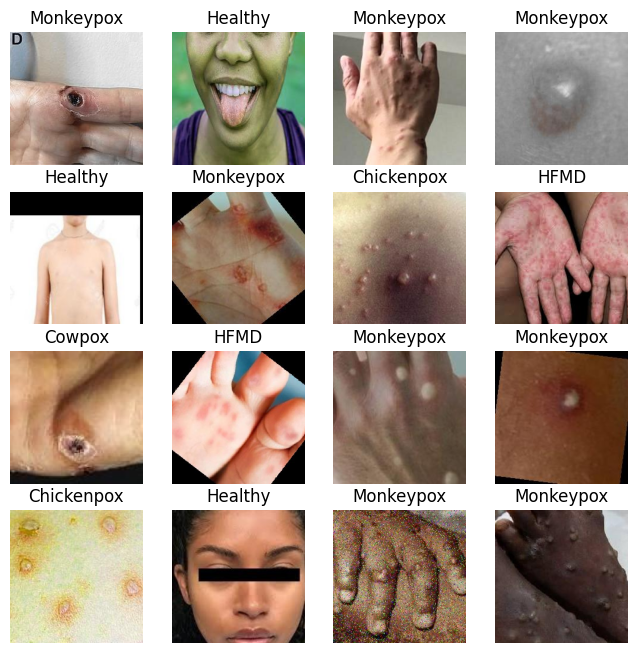

In [ ]:
# DIsplay the sample data
a = train_data.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[8, 10])
    for i in range(len(img)):
        plt.subplot(5, 4, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()
plot_images(x,y)

In [ ]:
def class_distrubution(folder):
  # Calculate class distribution
  class_names = os.listdir(folder)
  class_dis = [len(os.listdir(folder + "/" + name)) for name in class_names]
  fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
  fig.update_layout(title_x = 0.47)
  fig.show()



In [ ]:
class_distrubution(train_folder)
#class_distrubution(val_folder)

Perform Upsampling

In [ ]:
# Extract features and labels
X_train, y_train = [], []

for i in range(len(train_data)):
    X_batch, y_batch = train_data[i]
    X_train.extend(X_batch)
    y_train.extend(y_batch)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Get the class counts
class_counts = np.sum(y_train, axis=0)

# Find the class with the maximum count
max_class_count = int(np.max(class_counts))

# Upsample minority classes
X_upsampled, y_upsampled = [], []

for i in range(len(class_counts)):
    X_class = X_train[y_train[:, i] == 1]
    y_class = y_train[y_train[:, i] == 1]

    # Upsample the minority class
    X_class_upsampled, y_class_upsampled = resample(X_class, y_class, replace=True, n_samples=max_class_count, random_state=42)

    X_upsampled.extend(X_class_upsampled)
    y_upsampled.extend(y_class_upsampled)

X_upsampled = np.array(X_upsampled)
y_upsampled = np.array(y_upsampled)

# Shuffle the upsampled data
indices = np.arange(len(X_upsampled))
np.random.shuffle(indices)

X_upsampled = X_upsampled[indices]
y_upsampled = y_upsampled[indices]

# Convert one-hot encoded labels to class labels
y_upsampled_classes = np.argmax(y_upsampled, axis=1)

# Count the occurrences of each class
class_counts_upsampled = np.bincount(y_upsampled_classes)

# Print the counts
for class_index, count in enumerate(class_counts_upsampled):
    print(f"Class {class_index}: {count} images")


Class 0: 2968 images
Class 1: 2968 images
Class 2: 2968 images
Class 3: 2968 images
Class 4: 2968 images
Class 5: 2968 images


In [ ]:
#Create a new ImageDataGenerator with augmentation

class AugmentedDataGenerator(Sequence):
    def __init__(self, X, y, batch_size, datagen):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.datagen = datagen
        self.indexes = np.arange(len(self.X))

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_indexes]
        y_batch = self.y[batch_indexes]

        augmented_X_batch = np.array([self.datagen.random_transform(img) for img in X_batch])

        return augmented_X_batch, y_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

# Create an instance of the augmented data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_train_data = AugmentedDataGenerator(X_upsampled, y_upsampled, BATCH_SIZE, train_datagen)



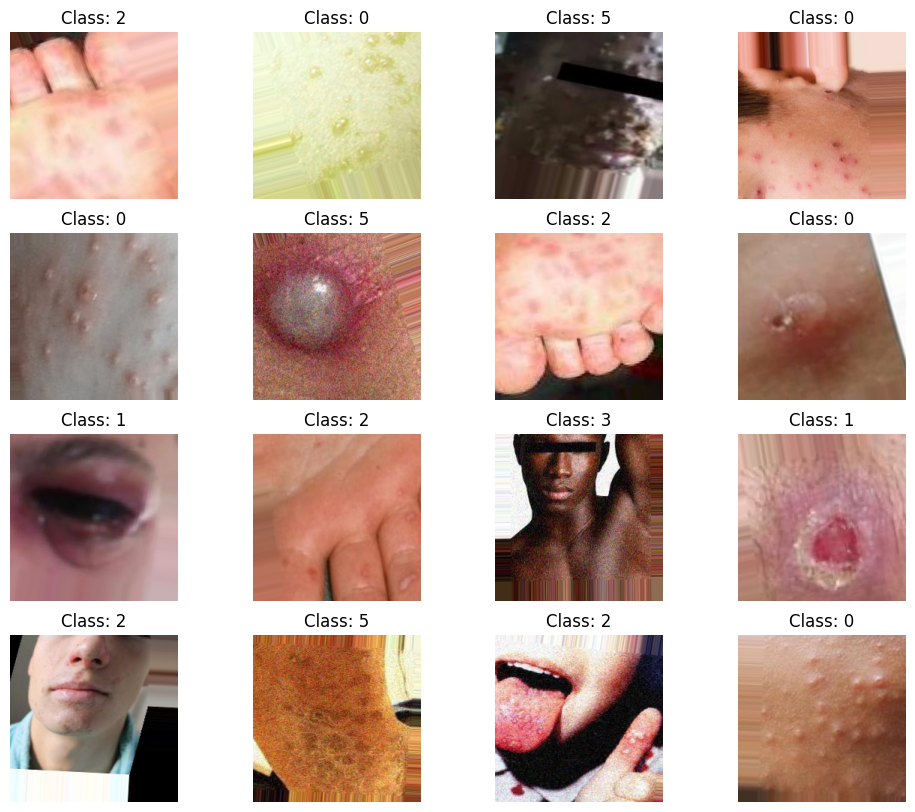

In [ ]:
# Display images from AugmentedDataGenerator
def display_augmented_images(data_generator, num_images=16):
    X_batch, y_batch = data_generator.__getitem__(0)
    y_classes = np.argmax(y_batch, axis=1)

    plt.figure(figsize=(12, 10))
    for i in range(num_images):
        ax = plt.subplot(4, 4, i + 1)
        img = X_batch[i]
        plt.imshow(img)
        plt.title(f"Class: {y_classes[i]}")
        plt.axis("off")
    plt.show()

display_augmented_images(augmented_train_data)

# Building the Model

## Model 1 : ResNet50

In [ ]:
# # Create TensorFlow datasets from ImageDataGenerators(to be continused from above where we created train_data, val_data, test_data from flow_from_directory command)
# train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, train_data.num_classes]))
# val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, val_data.num_classes]))
# test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, test_data.num_classes]))

# # Apply prefetch and autotune
# train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Callbacks are used to perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).
# In our case, we are using Modelcheckpoint for saving the model weights into the disk for a minimum value of validation loss. Further,
# we are also using ReduceLROnPlateau for reducing the learning rate of the model by a factor of 0.5 if its validation loss doesn’t improve for 3 consecutive epochs.

checkpoint = ModelCheckpoint('.mdl1_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [ ]:
# Load the ResNet50 model pretrained on ImageNet data and use fine tuning

conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
conv_base.trainable = True

model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation = "softmax"))

# Compile the model
model.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

# Train the model
history = model.fit(augmented_train_data,batch_size=BATCH_SIZE,callbacks=callbacks, validation_data= val_data,epochs=20,verbose=1)

Epoch 1/20
1113/1113 [==============================] - ETA: 0s - loss: 0.5666 - accuracy: 0.8151
Epoch 1: val_accuracy improved from -inf to 0.74675, saving model to .mdl1_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1113/1113 [==============================] - 1210s 1s/step - loss: 0.5666 - accuracy: 0.8151 - val_loss: 1.3969 - val_accuracy: 0.7468 - lr: 1.0000e-04
Epoch 2/20
1113/1113 [==============================] - ETA: 0s - loss: 0.2162 - accuracy: 0.9270
Epoch 2: val_accuracy improved from 0.74675 to 0.75974, saving model to .mdl1_wts.hdf5
1113/1113 [==============================] - 1186s 1s/step - loss: 0.2162 - accuracy: 0.9270 - val_loss: 1.0656 - val_accuracy: 0.7597 - lr: 1.0000e-04
Epoch 3/20
1113/1113 [==============================] - ETA: 0s - loss: 0.1600 - accuracy: 0.9481
Epoch 3: val_accuracy improved from 0.75974 to 0.80519, saving model to .mdl1_wts.hdf5
1113/1113 [==============================] - 1187s 1s/step - loss: 0.1600 - accuracy: 0.9481 - val_loss: 0.7435 - val_accuracy: 0.8052 - lr: 1.0000e-04
Epoch 4/20
1113/1113 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9516
Epoch 4: val_accuracy did not improve from 0.80519
1113/1113 [==============

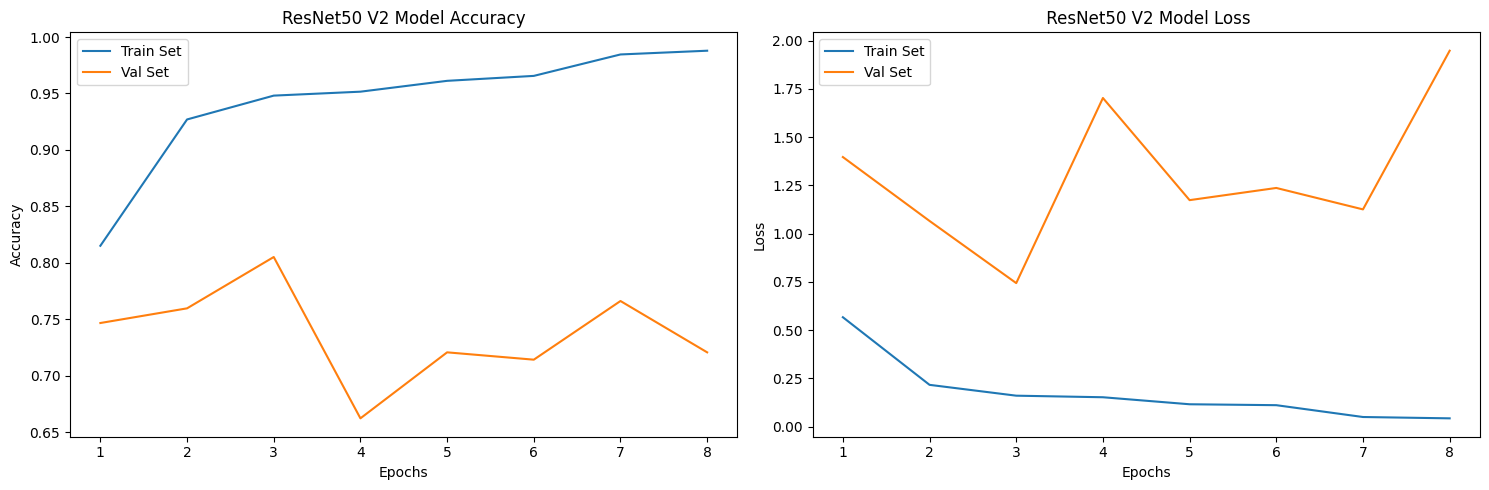

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' ResNet50 V2 Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl1_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 4s 291ms/step - loss: 0.7435 - accuracy: 0.8052
[0.7435206770896912, 0.8051947951316833]


model performed moderately well on test data with an overall validation accuracy of ---%. But now we will evaluate it on completely unseen test data so that we can assess its performance in a real sense

In [ ]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 1s 345ms/step - loss: 0.5335 - accuracy: 0.8730

 Test_Accuracy:- 0.8730158805847168


Confusion Matrix

4/4 [==============================] - 2s 268ms/step
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.78      1.00      0.88         7
           2       0.88      0.93      0.90        15
           3       0.91      1.00      0.95        10
           4       1.00      0.50      0.67         6
           5       0.84      0.89      0.86        18

    accuracy                           0.87        63
   macro avg       0.90      0.84      0.85        63
weighted avg       0.89      0.87      0.87        63



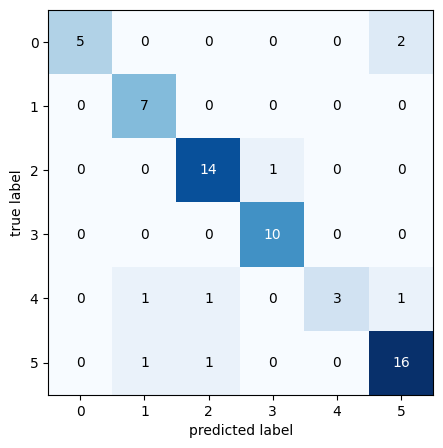

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("ResNet50-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

ResNet50-based Model Accuracy: 87.30%
Precision: 0.901
Recall: 0.839
F1 Score: 0.849


## Model 2: MobileNet V2



In [ ]:
conv_base = MobileNetV2(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(6, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [ ]:
# Define the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']        

In [ ]:
checkpoint = ModelCheckpoint('.mdl2_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [ ]:
history = model.fit(augmented_train_data,batch_size=BATCH_SIZE,callbacks=callbacks, validation_data=val_data,epochs=20,verbose=1)

Epoch 1/20
1113/1113 [==============================] - ETA: 0s - loss: 1.1747 - accuracy: 0.5961
Epoch 1: val_accuracy improved from -inf to 0.13636, saving model to .mdl2_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1113/1113 [==============================] - 382s 332ms/step - loss: 1.1747 - accuracy: 0.5961 - val_loss: 7.1431 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 2/20
1113/1113 [==============================] - ETA: 0s - loss: 0.7130 - accuracy: 0.7710
Epoch 2: val_accuracy improved from 0.13636 to 0.28571, saving model to .mdl2_wts.hdf5
1113/1113 [==============================] - 363s 326ms/step - loss: 0.7130 - accuracy: 0.7710 - val_loss: 3.9320 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 3/20
1113/1113 [==============================] - ETA: 0s - loss: 0.5320 - accuracy: 0.8341
Epoch 3: val_accuracy improved from 0.28571 to 0.36364, saving model to .mdl2_wts.hdf5
1113/1113 [==============================] - 364s 327ms/step - loss: 0.5320 - accuracy: 0.8341 - val_loss: 3.3339 - val_accuracy: 0.3636 - lr: 0.0010
Epoch 4/20
1113/1113 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.8653
Epoch 4: val_accuracy improved from 0.36364 to 0.48052, saving model to .mdl2_wts.

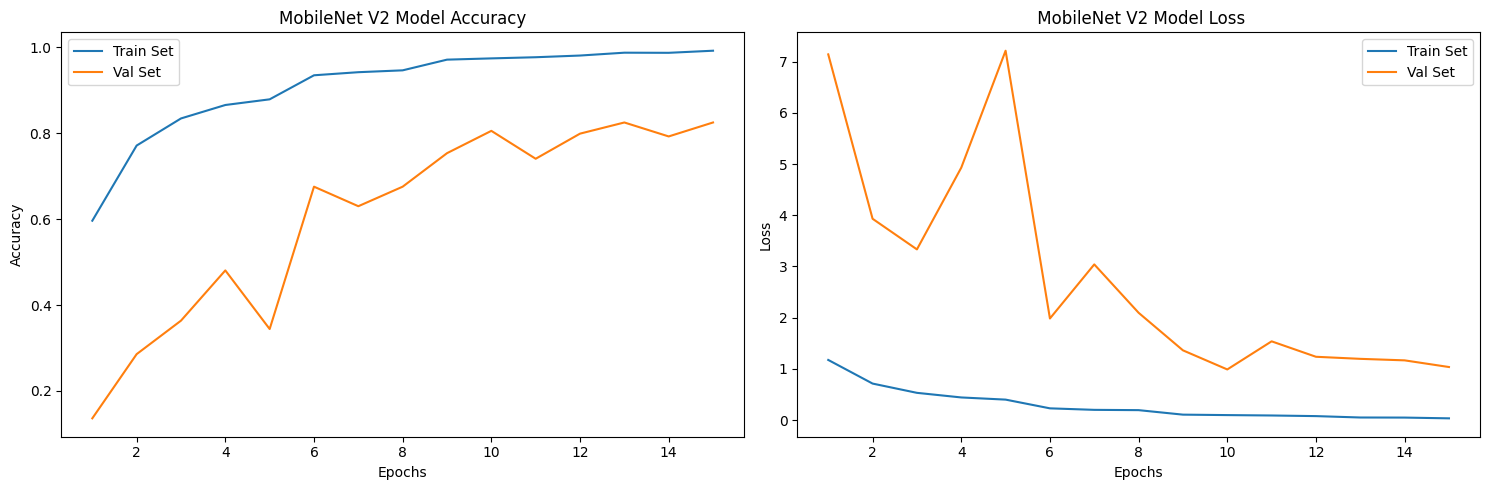

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' MobileNet V2 Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl2_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 2s 75ms/step - loss: 1.1961 - accuracy: 0.8247
[1.196055293083191, 0.8246753215789795]


In [ ]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 0s 77ms/step - loss: 0.6674 - accuracy: 0.8730

 Test_Accuracy:- 0.8730158805847168


4/4 [==============================] - 1s 72ms/step
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      0.57      0.73         7
           2       0.83      1.00      0.91        15
           3       1.00      1.00      1.00        10
           4       0.80      0.67      0.73         6
           5       0.80      0.89      0.84        18

    accuracy                           0.87        63
   macro avg       0.91      0.83      0.85        63
weighted avg       0.88      0.87      0.87        63



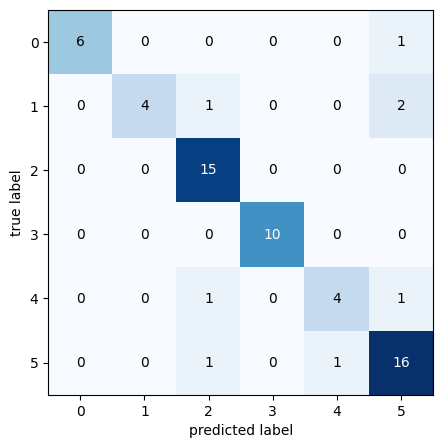

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("MobileNet-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

MobileNet-based Model Accuracy: 87.30%
Precision: 0.906
Recall: 0.831
F1 Score: 0.855


### Model 3 : DenseNet121


In [ ]:
checkpoint = ModelCheckpoint('.mdl3_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Load the DenseNet121 model pretrained on ImageNet data
conv_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Allow fine-tuning of the whole model
conv_base.trainable = True

# Add custom layers on top of the base model
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)
model = Model(inputs=conv_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

# Train the model
history = model.fit(augmented_train_data, batch_size=BATCH_SIZE, callbacks=callbacks, validation_data=val_data, epochs=20, verbose=1)


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/20
1113/1113 [==============================] - ETA: 0s - loss: 0.3119 - accuracy: 0.8894
Epoch 1: val_accuracy improved from -inf to 0.75325, saving model to .mdl3_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1113/1113 [==============================] - 1188s 1s/step - loss: 0.3119 - accuracy: 0.8894 - val_loss: 0.8084 - val_accuracy: 0.7532 - lr: 1.0000e-04
Epoch 2/20
1113/1113 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9637
Epoch 2: val_accuracy improved from 0.75325 to 0.77922, saving model to .mdl3_wts.hdf5
1113/1113 [==============================] - 1152s 1s/step - loss: 0.1072 - accuracy: 0.9637 - val_loss: 1.0926 - val_accuracy: 0.7792 - lr: 1.0000e-04
Epoch 3/20
1113/1113 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9693
Epoch 3: val_accuracy did not improve from 0.77922

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1113/1113 [==============================] - 1150s 1s/step - loss: 0.0854 - accuracy: 0.9693 - val_loss: 1.4993 - val_accuracy: 0.7662 - lr: 1.0000e-04
Epoch 4/20
1113/1113 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9912
Epoch 4: val_accuracy improved from

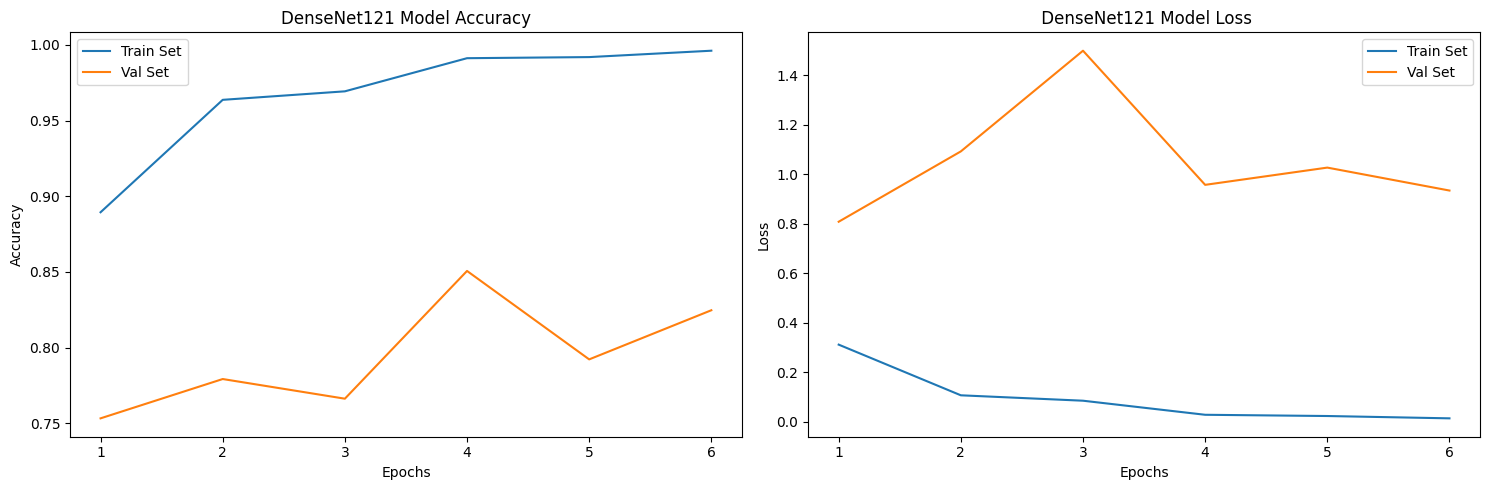

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('DenseNet121 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' DenseNet121 Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl3_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 4s 248ms/step - loss: 0.9574 - accuracy: 0.8506
[0.957445502281189, 0.850649356842041]


In [ ]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 1s 264ms/step - loss: 0.5613 - accuracy: 0.8889

 Test_Accuracy:- 0.8888888955116272


4/4 [==============================] - 3s 246ms/step
              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       1.00      1.00      1.00         7
           2       0.83      1.00      0.91        15
           3       0.91      1.00      0.95        10
           4       1.00      0.50      0.67         6
           5       0.94      0.89      0.91        18

    accuracy                           0.89        63
   macro avg       0.90      0.85      0.86        63
weighted avg       0.90      0.89      0.88        63



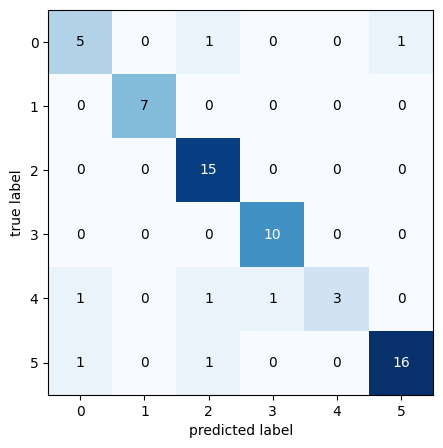

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("DenseNet121-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

DenseNet121-based Model Accuracy: 88.89%
Precision: 0.900
Recall: 0.851
F1 Score: 0.859


Instructions for updating:
Colocations handled automatically by placer.


102967424/102967424 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/innvestigate/backend/graph.py:467: UserWarning:

Ignore dtype <dtype: 'float32'> as bias type.

/usr/local/lib/python3.10/dist-packages/innvestigate/backend/graph.py:480: UserWarning:

Ignore dtype <dtype: 'float32'> as bias type.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



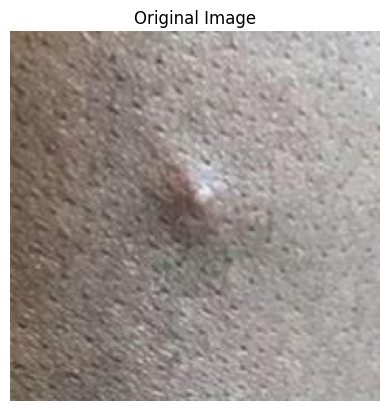

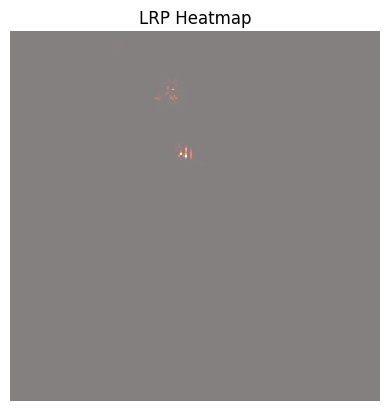

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import innvestigate

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load pre-trained model
model = ResNet50(weights='imagenet')

# Create a new model that excludes the softmax layer
model_without_softmax = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output  # Output of the layer before softmax
)

# Load an image
img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_12_01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create an analyzer
analyzer = innvestigate.create_analyzer("lrp.epsilon", model_without_softmax)

# Analyze the image
analysis = analyzer.analyze(x)

# Postprocess the relevance map
analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
analysis /= analysis.max()  # Normalize to [0, 1]

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

# Display the relevance heatmap
plt.imshow(analysis, cmap="hot", alpha=0.5, interpolation='nearest')
plt.axis('off')
plt.title('LRP Heatmap')
plt.show()


33188688/33188688 [==============================] - 0s 0us/step


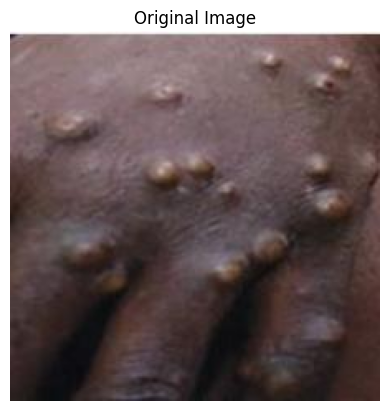

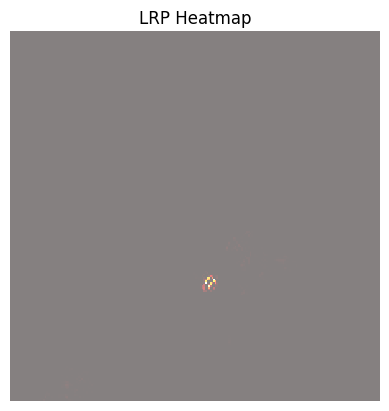

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing import image
import innvestigate

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load pre-trained model
model = DenseNet121(weights='imagenet')

# Create a new model that excludes the softmax layer
model_without_softmax = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output  # Output of the layer before softmax
)

# Load an image
img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_44_01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create an analyzer
analyzer = innvestigate.create_analyzer("lrp.epsilon", model_without_softmax)

# Analyze the image
analysis = analyzer.analyze(x)

# Postprocess the relevance map
analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
analysis /= analysis.max()  # Normalize to [0, 1]

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

# Display the relevance heatmap
plt.imshow(analysis, cmap="hot", alpha=0.5, interpolation='nearest')
plt.axis('off')
plt.title('LRP Heatmap')
plt.show()

